# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
from lightning.pytorch import seed_everything

seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

Seed set to 8


--------
### 実験設定

In [2]:
SAMPLE_SIZE = 100  # 標本サイズ
DATA_SIZE = 100000  # データサイズ(df2)
N_TRIALS = 1000  # 試行回数（標本平均を求める回数）
N_EXPERIMENT = 10  # 分散を求める回数
m_VALUE = 2  # 各クラスタの最小標本数(最適標本配分)
RANDOM_STATE = 0  # 乱数シード
ALLOCATION_METHODS = [
    "ProportionalAllocation",
    "PostStratification",
    "OptimalAllocation",
]  # "RandomAllocation"はいれない
CLUSTERING_METHOD = "xmeans"  # "gmm" or "kmeans" or "xmeans"

# クラスタを固定する場合(gmm, kmeans)
N_CLUSTERS = 2  # クラスタ数

# クラスタ数を固定しない場合（xmeans)
K_MIN = 2
K_MAX = 10


MAXIMUM_FEATURES_TO_SELECT = 10  # 選択される最大の特徴量数

SELECTING_FEATURES = (
    "all_features"  # "all_features" or "not_all_features" #特徴量をすべて選ぶかどうか
)

-----------
### データの前処理（Data Preprocessing）

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### メルカリデータ（df1：全部, df2：一部）

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
obj1 = "GMV"
features_list1 = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]
obj2 = obj1
features_list2 = features_list1

##### 外れ値除去と標準化

In [5]:
df = df2  # choose from (df1, df2)
obj = obj2  # choose from (obj1, obj2)
features_list = features_list2  # choose from (features_list1, features_list2)

# 外れ値除去
df = remove_outliers_zscore(df, obj)

# 標準化
X = df[features_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns=features_list)

# 目的変数
y = df[obj]

# 行を詰める
df = df.reset_index(drop=True)

-------------
### 提案手法でクラスタリング

##### Allocation_in_Wrapper Class
とりあえずproportional でやってみる  
・データによってはクラスタ数=3と指定した場合も2になることもある  
⇒ この場合はscore = 0  
・クラスタ数が多すぎると母集団のある層のデータ数が１になることがある⇒最適標本配分ができない

In [6]:
class Allocation_in_Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        maximum_features_to_select: int,
        n_clusters: int,
        clustering_method: str = "kmeans",
        allocation_methods: list[str] = ["ProportionalAllocation"],
        sample_size: int = 10,
        n_trials: int = 100,
        m_value=2,
        M: Optional[NDArray] = None,
        random_state: int = 0,
        selecting_features: str = "all_features",
        k_min: int = 2,
        k_max: int = 10,
    ):
        self.maximum_features_to_select = maximum_features_to_select
        self.n_clusters = n_clusters
        self.clustering_method = clustering_method
        self.allocation_methods = allocation_methods
        self.sample_size = sample_size
        self.n_trials = n_trials
        self.m_value = m_value
        self.M = M
        self.random_state = random_state
        self.selecting_features = selecting_features
        self.k_min = k_min
        self.k_max = k_max

    def fss(
        self, X: pd.DataFrame, y: pd.DataFrame
    ) -> "Allocation_in_Wrapper":  ###これ自体は多分あってる
        X, y = check_X_y(X, y)
        n_features = X.shape[1]  # 総特徴量数
        self.selected_features_dict = {}
        self.final_cluster_assignments_dict = {}
        self.features_score_dict_dict = {}
        self.features_error_variance_dict_dict = {}
        self.final_n_clusters_dict = {}

        # ランダムの分散を計算
        self.random_allocation_std = self.cauculate_random_std(X, y)
        print("random_std", self.random_allocation_std)

        # 特徴量選択
        for allocation_method in self.allocation_methods:
            print("[", allocation_method, "]")

            features_score_dict = {}  # 確認用 ###############
            features_error_variance_dict = {}

            # 選ばれた特徴量と残っている特徴量の初期化
            current_features = []
            remaining_features = list(range(n_features))
            best_labels = [-1 for i in range(len(X))]
            best_n_clusters = -1
            if self.selecting_features == "not_all_features":
                best_score = -np.inf

            while len(current_features) < self.maximum_features_to_select:
                if self.selecting_features == "all_features":
                    best_score = -np.inf
                best_feature = None  # 選ぶ特徴量の初期化

                for feature in remaining_features:
                    temp_features = tuple(
                        current_features + [feature]
                    )  # 特徴量をひとつ加え、score計算
                    score, error_variance, n_clusters = self.crit(
                        X[:, temp_features], y, allocation_method
                    )
                    if score > best_score:
                        best_score = score
                        best_error_variance = error_variance
                        best_feature = feature
                        best_labels = self.N_cluster_label
                        best_n_clusters = n_clusters

                if best_feature is not None:
                    current_features.append(
                        best_feature
                    )  # best feature をcurrent features に追加
                    num_of_features = len(current_features)
                    print(
                        "num_of_features:",
                        num_of_features,
                        "current_features:",
                        current_features,
                        ", score:",
                        best_score,
                        "best_n_clusters:",
                        best_n_clusters,
                    )

                    features_score_dict[str(num_of_features)] = best_score  # 確認用
                    features_error_variance_dict[str(num_of_features)] = (
                        best_error_variance
                    )

                    remaining_features.remove(
                        best_feature
                    )  # best feature をremaining features から取り除く
                    self.selected_features_ = current_features
                else:
                    break

            self.final_cluster_assignments_dict[allocation_method] = best_labels
            self.final_n_clusters_dict[allocation_method] = best_n_clusters
            self.features_score_dict_dict[allocation_method] = features_score_dict
            self.features_error_variance_dict_dict[allocation_method] = (
                features_error_variance_dict
            )
            self.selected_features_dict[allocation_method] = self.selected_features_

        return self

    def crit(self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str) -> float:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            model = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
        # クラスタリング手法がKMEANSの場合
        if self.clustering_method == "kmeans":
            model = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
        if self.clustering_method == "xmeans":
            model = self.xmeans(X)

        model.fit(X)
        self.N_cluster_label = model.predict(X)
        self.N_cluster_size = np.bincount(self.N_cluster_label)
        n_clusters = len(np.unique(self.N_cluster_label))

        error_variance_reduction_rate, error_variance = self.cauculate_reduction_rate(
            X, y, allocation_method
        )
        score = error_variance_reduction_rate

        return score, error_variance, n_clusters

    def compute_bic(self, X, kmeans):
        # クラスタリング結果の取得
        labels = kmeans.labels_
        clusters = kmeans.cluster_centers_
        n_clusters = len(clusters)
        n = len(X)
        m = X.shape[1]
        # クラスター内の分散の合計
        variance = np.sum(
            [
                np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
                for i in range(n_clusters)
            ]
        )
        # BIC の計算
        bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
        return bic

    def xmeans(self, X):
        kmeans = KMeans(n_clusters=self.k_min)  # 初期クラスター数で KMeans を実行
        kmeans.fit(X)
        best_bic = self.compute_bic(X, kmeans)
        best_kmeans = kmeans
        for k in range(self.k_min + 1, self.k_max + 1):
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(X)
            # BIC を計算
            current_bic = self.compute_bic(X, kmeans)
            # BIC が改善される場合、クラスタ数を更新
            if current_bic < best_bic:
                best_bic = current_bic
                best_kmeans = kmeans
        # 最適なクラスタリング結果を返す
        return best_kmeans

    def cauculate_reduction_rate(
        self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str
    ) -> float:
        # 各戦略の標本数に基づいて目的変数の平均を推定
        y_hats = []
        for random_state in range(self.n_trials):
            if allocation_method == "PostStratification":
                y_hat = self.estimate_y_mean_post(X, y)
            else:
                y_hat = self.estimate_y_mean_other(X, y, allocation_method)
            y_hats.append(
                {
                    "policy": allocation_method,
                    "y_hat": y_hat,
                    "random_state": random_state,
                }
            )

        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = (
            y_hat_df["y_hat"] - y.mean()
        )  # 真の平均からの誤差をerrorカラムに追加

        non_random_allocation_std = y_hat_df["error"].var()
        # 削減率
        reduction_rate = (
            1 - non_random_allocation_std / self.random_allocation_std
        ) * 100

        return reduction_rate, non_random_allocation_std

    def cauculate_random_std(self, X, y):
        y_hats = []
        for random_state in range(self.n_trials):
            sample = np.random.choice(y, self.sample_size, replace=False)
            y_hat_random = sample.mean()
            y_hats.append(
                {
                    "policy": "RandomAllocation",
                    "y_hat": y_hat_random,
                    "random_state": random_state,
                }
            )

        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = y_hat_df["y_hat"] - y.mean()
        random_allocation_std = y_hat_df["error"].var()
        return random_allocation_std

    def estimate_y_mean_post(self, X, y) -> float:
        n_cluster_size = np.array([self.sample_size])
        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        indices = np.arange(self.N_cluster_size.sum())
        y_array = np.array(y.tolist())
        n_indices = np.random.choice(indices, n_cluster_size[0], replace=False)
        n_label = np.array([self.N_cluster_label[i] for i in n_indices])
        n_new_labels = np.unique(n_label)
        for h in n_new_labels:
            index = np.where(n_label == h)[0]
            sample = y_array[n_indices[index]]
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[h]
        return y_hat

    def estimate_y_mean_other(self, X, y, allocation_method) -> float:
        if allocation_method == "ProportionalAllocation":
            n_cluster_size = self.ProportionalAllocation(X, y)
        if allocation_method == "OptimalAllocation":
            n_cluster_size = self.OptimalAllocation(X, y)

        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        for h in range(n_cluster_size.shape[0]):
            if n_cluster_size[h] != 0:
                y_cluster = y[self.N_cluster_label == h]
                if n_cluster_size[h] <= len(y_cluster):
                    sample: NDArray = np.random.choice(
                        y_cluster, n_cluster_size[h], replace=False
                    )
                    y_sample_mean = sample.mean()  # サンプリングした標本の平均
                    y_hat += y_sample_mean * weights[h]
        return y_hat

    def ProportionalAllocation(self, X, y) -> NDArray:
        n_cluster_size: NDArray = np.round(
            self.N_cluster_size / self.N_cluster_size.sum() * self.sample_size
        ).astype(int)

        if n_cluster_size.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n_cluster_size[np.argmax(n_cluster_size)] -= (
                n_cluster_size.sum() - self.sample_size
            )
        if n_cluster_size.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n_cluster_size[np.argmax(n_cluster_size)] += (
                -n_cluster_size.sum() + self.sample_size
            )

        return n_cluster_size

    def OptimalAllocation(self, X, y) -> NDArray:  # たぶんあってる
        n_cluster = len(np.unique(self.N_cluster_label))
        self.m = np.full(n_cluster, self.m_value)
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.N_cluster_label == h]) for h in range(n_cluster)])

        d = (self.N_cluster_size**2) * S

        n_cluster_size = self.m.copy()  # 初期値

        M = self.M.copy() if self.M is not None else self.N_cluster_size.copy()
        I = np.arange(self.n_clusters)  # noqa #クラスタのインデックス
        while (n_cluster_size.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(self.n_clusters)
            delta[I] = (d / (n_cluster_size + 1) - d / n_cluster_size)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n_cluster_size[h_star] + 1 <= M[h_star]:
                n_cluster_size[h_star] = n_cluster_size[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        # 制約チェック
        assert (
            n_cluster_size.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n_cluster_size >= self.m
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n_cluster_size <= self.M
            ), "Maximum sample size constraint is not satisfied"

        return n_cluster_size

    def get_feature_index_out(self) -> dict[NDArray]:
        return self.selected_features_dict  # 選択された特徴量のインデックス

    def get_final_cluster_assignments(self) -> dict[NDArray]:
        return self.final_cluster_assignments_dict  # 最終的なクラスタリング結果

    def get_features_score_dict_dict(self) -> dict[dict]:
        return self.features_score_dict_dict

    def get_features_error_variance_dict_dict(self) -> dict[dict]:
        return self.features_error_variance_dict_dict

    def get_final_n_clusters_dict(self) -> dict:
        return self.final_n_clusters_dict

    def get_random_allocation_std(self) -> float:
        return self.random_allocation_std

In [7]:
ins = Allocation_in_Wrapper(
    maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
    n_clusters=N_CLUSTERS,
    clustering_method=CLUSTERING_METHOD,
    allocation_methods=ALLOCATION_METHODS,
    sample_size=SAMPLE_SIZE,
    n_trials=N_TRIALS,
    m_value=m_VALUE,
    random_state=RANDOM_STATE,
    selecting_features=SELECTING_FEATURES,
    k_min=K_MIN,
    k_max=K_MAX,
)

ins.fss(X_scaled, y)
selected_features_index = ins.get_feature_index_out()
cluster_label = ins.get_final_cluster_assignments()
cluster_size = np.unique(cluster_label, return_counts=True)[1]
features_score_dict_dict = ins.get_features_score_dict_dict()
features_error_variance_dict_dict = ins.get_features_error_variance_dict_dict()
random_std = ins.get_random_allocation_std()
print(features_score_dict_dict)

random_std 231297.86061875863
[ ProportionalAllocation ]


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Po

num_of_features: 1 current_features: [5] , score: 17.820845421694376 best_n_clusters: 10
num_of_features: 2 current_features: [5, 4] , score: 23.850064529892776 best_n_clusters: 10
num_of_features: 3 current_features: [5, 4, 6] , score: 23.36837041747074 best_n_clusters: 10
num_of_features: 4 current_features: [5, 4, 6, 10] , score: 25.339790405565697 best_n_clusters: 10
num_of_features: 5 current_features: [5, 4, 6, 10, 12] , score: 23.970392266301022 best_n_clusters: 10
num_of_features: 6 current_features: [5, 4, 6, 10, 12, 7] , score: 24.074432917618505 best_n_clusters: 10
num_of_features: 7 current_features: [5, 4, 6, 10, 12, 7, 16] , score: 24.87592769649113 best_n_clusters: 10
num_of_features: 8 current_features: [5, 4, 6, 10, 12, 7, 16, 14] , score: 20.92720146231858 best_n_clusters: 10
num_of_features: 9 current_features: [5, 4, 6, 10, 12, 7, 16, 14, 13] , score: 23.574299600076067 best_n_clusters: 10
num_of_features: 10 current_features: [5, 4, 6, 10, 12, 7, 16, 14, 13, 3] , s

c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate p

num_of_features: 1 current_features: [5] , score: 11.91298646989124 best_n_clusters: 10
num_of_features: 2 current_features: [5, 4] , score: 25.888944285921013 best_n_clusters: 10
num_of_features: 3 current_features: [5, 4, 3] , score: 22.267167214495963 best_n_clusters: 10
num_of_features: 4 current_features: [5, 4, 3, 15] , score: 21.184828280025037 best_n_clusters: 9
num_of_features: 5 current_features: [5, 4, 3, 15, 0] , score: 17.59016565664201 best_n_clusters: 10
num_of_features: 6 current_features: [5, 4, 3, 15, 0, 8] , score: 18.780621744786096 best_n_clusters: 10
num_of_features: 7 current_features: [5, 4, 3, 15, 0, 8, 14] , score: 17.059073415879457 best_n_clusters: 10
num_of_features: 8 current_features: [5, 4, 3, 15, 0, 8, 14, 16] , score: 22.346687066303915 best_n_clusters: 10
num_of_features: 9 current_features: [5, 4, 3, 15, 0, 8, 14, 16, 9] , score: 18.440768241776507 best_n_clusters: 10
num_of_features: 10 current_features: [5, 4, 3, 15, 0, 8, 14, 16, 9, 1] , score: 18

c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate p

num_of_features: 1 current_features: [2] , score: 2.0530685270843008 best_n_clusters: 2
num_of_features: 2 current_features: [2, 10] , score: 8.176020880551238 best_n_clusters: 10
num_of_features: 3 current_features: [2, 10, 8] , score: 1.9409309514853867 best_n_clusters: 10
num_of_features: 4 current_features: [2, 10, 8, 9] , score: -24.784019561597702 best_n_clusters: 8
num_of_features: 5 current_features: [2, 10, 8, 9, 0] , score: -2.8500534913813658 best_n_clusters: 10
num_of_features: 6 current_features: [2, 10, 8, 9, 0, 5] , score: -28.660793958146623 best_n_clusters: 9
num_of_features: 7 current_features: [2, 10, 8, 9, 0, 5, 16] , score: -36.060301129250114 best_n_clusters: 10
num_of_features: 8 current_features: [2, 10, 8, 9, 0, 5, 16, 11] , score: -34.68382220950108 best_n_clusters: 10
num_of_features: 9 current_features: [2, 10, 8, 9, 0, 5, 16, 11, 1] , score: -15.15941404650929 best_n_clusters: 10
num_of_features: 10 current_features: [2, 10, 8, 9, 0, 5, 16, 11, 1, 7] , scor

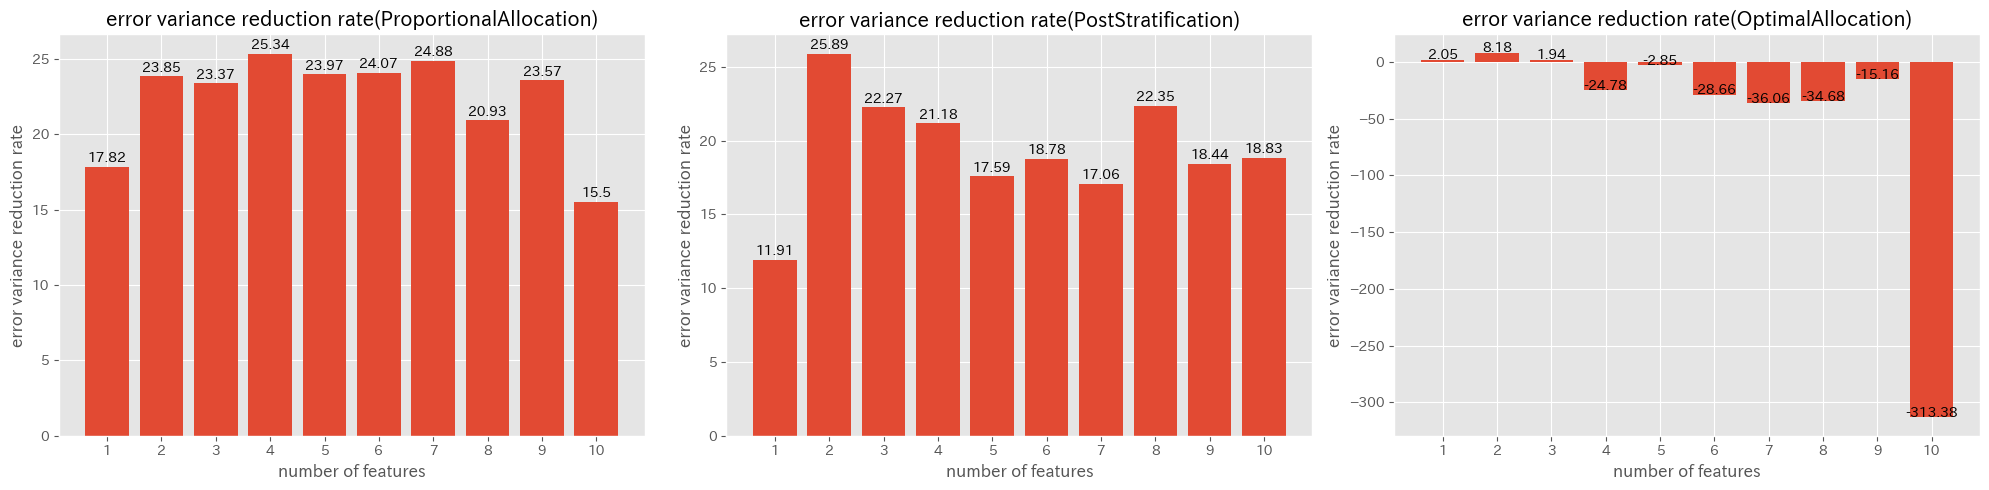

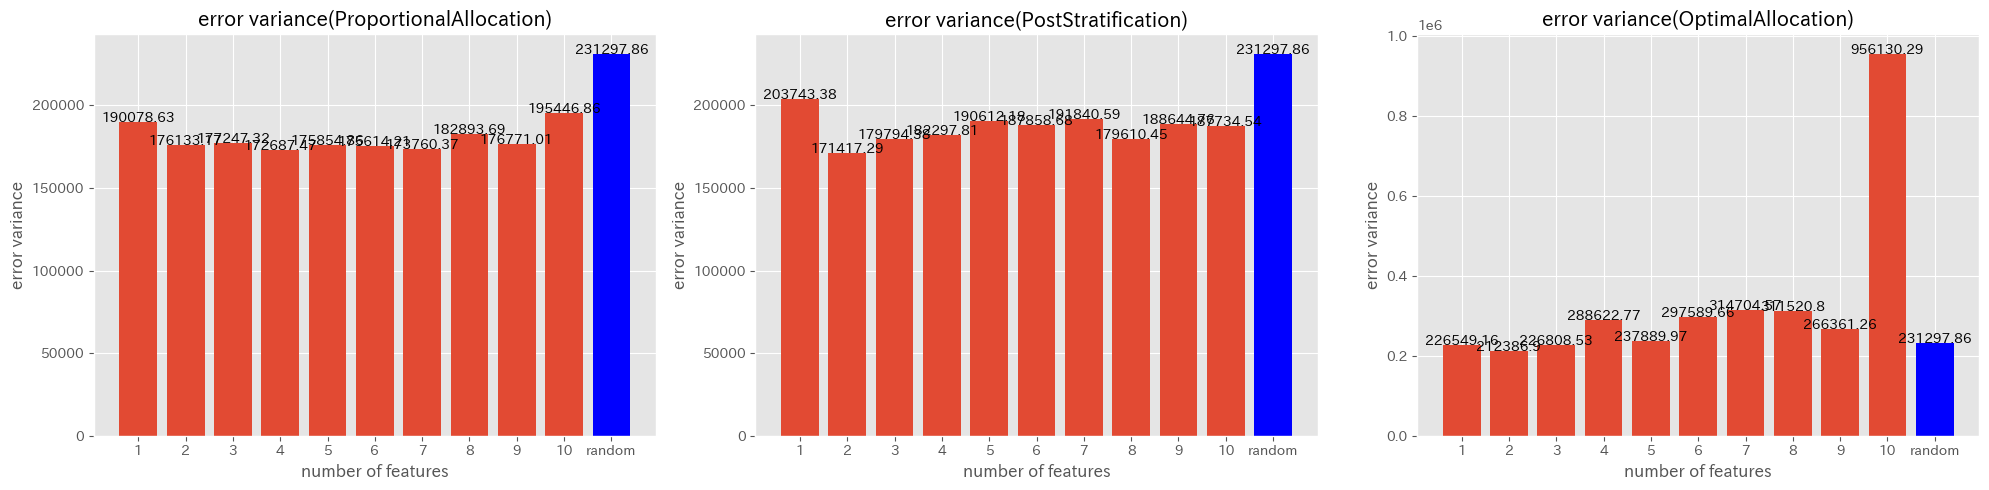

In [8]:
# グラフ作成
fig, axs = plt.subplots(
    1, len(ALLOCATION_METHODS), figsize=(20, 5)
)  # サブプロットを作成

plot_idx = 0
for allocation, dict in features_score_dict_dict.items():
    ax = axs[plot_idx]
    bars = ax.bar(dict.keys(), dict.values())
    for key, value in dict.items():
        rounded_value = round(value, 2)
        ax.text(key, value + 0.3, str(rounded_value), ha="center")
    ax.set_title(f"error variance reduction rate({allocation})")
    ax.set_xlabel("number of features")
    ax.set_ylabel("error variance reduction rate")
    plot_idx += 1

plt.tight_layout()
plt.show()


# グラフ作成
fig, axs = plt.subplots(
    1, len(ALLOCATION_METHODS), figsize=(20, 5)
)  # サブプロットを作成

plot_idx = 0
for allocation, dict in features_error_variance_dict_dict.items():
    ax = axs[plot_idx]
    bars = ax.bar(dict.keys(), dict.values())
    for key, value in dict.items():
        rounded_value = round(value, 2)
        ax.text(key, value + 0.3, str(rounded_value), ha="center")
    random_bar = ax.bar("random", random_std, color="blue")
    ax.text("random", random_std + 0.3, str(round(random_std, 2)), ha="center")
    ax.set_title(f"error variance({allocation})")
    ax.set_xlabel("number of features")
    ax.set_ylabel("error variance")
    plot_idx += 1

plt.tight_layout()
plt.show()